# Redução ao pólo

Este código utiliza a biblioteca de modelagem e inversão de dados geofísicos denominada [Fatiando a Terra](http://www.fatiando.org/index.html) para comparar a transformação de redução ao pólo (Blakely, 1996; Nabighian et al., 2005) feita por meio da técnica da camada equivalente (Dampney, 1969; Emilia, 1973; Silva, 1986; Leão e Silva, 1989; Li e Oldenburg, 2010; Barnes e Lumley, 2011; Oliveira Jr. et al., 2013; Li et al., 2014) e da transformada de Fourier (Blakely, 1996).

* Dampney, C. N. G., 1969, The equivalent source technique: GEOPHYSICS, 34, 39-53. doi: [10.1190/1.1439996](http://dx.doi.org/10.1190/1.1439996)

* Emilia, D. A., 1973, Equivalent sources used as an analytic base for processing total magnetic field profiles: GEOPHYSICS, 38, 339-348. doi: [10.1190/1.1440344](http://dx.doi.org/10.1190/1.1440344)

* Silva, J. B. C., 1986, Reduction to the pole as an inverse problem and its application to low-latitude anomalies: GEOPHYSICS, 51, 369-382. doi: [10.1190/1.1442096](http://dx.doi.org/10.1190/1.1442096)

* Leão, J. W. D., e J. B. C. Silva, 1989, Discrete linear transformations of potential field data: GEOPHYSICS, 54, 497-507. doi: [10.1190/1.1442676](http://dx.doi.org/10.1190/1.1442676)

* Blakely, R. J., 1996, Potential theory in gravity and magnetic applications. Cambridge University Press. ISBN: 0-521-57547-8

* Nabighian, M. N., V. J. S. Grauch, R. O. Hansen, T. R. LaFehr, Y. Li, J. W. Peirce , J. D. Phillips e M. E. Ruder, 2005, 75th Anniversary - Historical development of the magnetic method in exploration. Geophysics, 70(6), p. 33ND–61ND. doi: [10.1190/1.2133784](http://dx.doi.org/10.1190/1.2133784)

* Li, Y., e D. W. Oldenburg, 2010, Rapid construction of equivalent sources using wavelets: GEOPHYSICS, 75, L51-L59. doi: [10.1190/1.3378764](http://dx.doi.org/10.1190/1.3378764)

* Barnes, G., e J. Lumley, 2011, Processing gravity gradient data: GEOPHYSICS, 76, I33-I47. doi: [10.1190/1.3548548](http://dx.doi.org/10.1190/1.3548548)

* Oliveira Jr., V. C., V. C. F. Barbosa, e L. Uieda, 2013, Polynomial equivalent layer: GEOPHYSICS, 78, G1-G13. doi: [10.1190/geo2012-0196.1](http://dx.doi.org/10.1190/geo2012-0196.1)

* Li, Y., M. Nabighian, e D. W. Oldenburg, 2014, Using an equivalent source with positivity for low-latitude reduction to the pole without striation: GEOPHYSICS, 79, J81-J90. doi: [10.1190/geo2014-0134.1](http://dx.doi.org/10.1190/geo2014-0134.1)

In [1]:
%matplotlib inline
import numpy as np
from fatiando import mesher, gridder, utils
from fatiando.gravmag import sphere, prism, transform
from fatiando.gravmag.eqlayer import EQLTotalField
from fatiando.inversion.regularization import Damping, LCurve
from fatiando.vis import mpl

### Pontos onde são calculados os dados

In [2]:
shape = (60, 60) # número de dados ao longo de x e y
N = shape[0]*shape[1] # número de dados
area = [-3000, 3000, -3000, 3000] # x mínimo, x máximo, y mínimo e y máximo da área

In [3]:
xp, yp = gridder.regular(area, shape) # grade regular

In [4]:
zp = -250.*utils.gaussian2d(xp, yp, 1000., 3000., -300.0, -600.0, 30.)
#zp = np.zeros_like(xp) - 100.

In [5]:
xc = 0.5*(area[1] + area[0])
yc = 0.5*(area[3] + area[2])

dx, dy = gridder.spacing(area, shape)

In [6]:
print dx
print dy

101.694915254
101.694915254


### Campo geomagnético local

In [7]:
inc = -3. # graus
dec = 40. # graus

### Corpos sintéticos

In [8]:
incs = inc
decs = dec
amps = 3.

model = [mesher.Prism(-500., 500., -1000., 1000., 10., 1010., \
                      {'magnetization': utils.ang2vec(amps, incs, decs)})]

In [9]:
# Projeção horizontal dos corpos
projecao = []
for i, p in enumerate(model):
    projecao.append(p.get_bounds()[:4])

### Anomalia de campo total (em nT)

In [10]:
act_aprox = prism.tf(xp, yp, zp, model, inc, dec)

### Plot dos dados

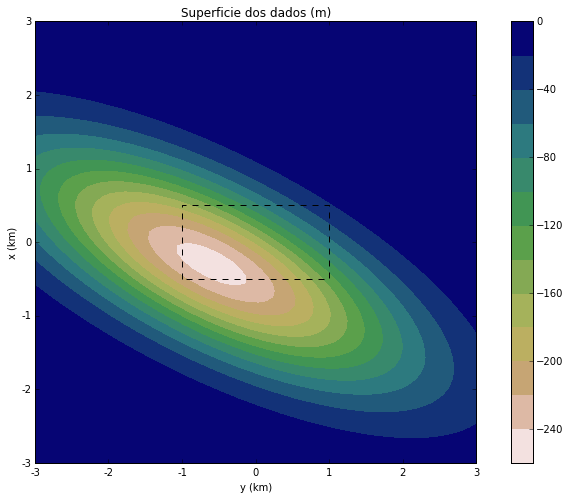

In [11]:
mpl.close('all')
mpl.figure(figsize=(10,7))

mpl.title("Superficie dos dados (m)")
mpl.axis('scaled')
mpl.contourf(yp, xp, zp, shape, 15, cmap=mpl.get_cmap('gist_earth_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.tight_layout()

mpl.show()

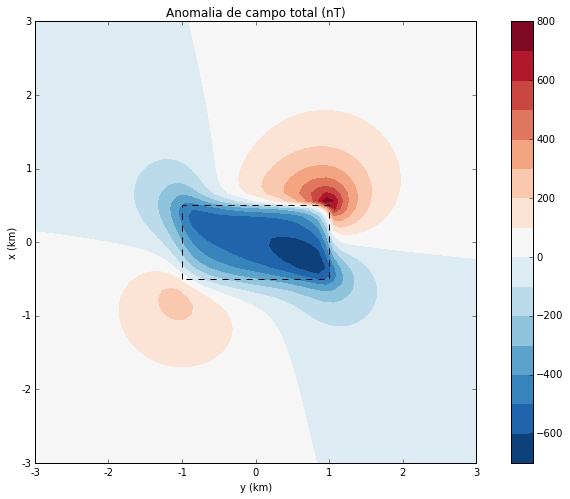

In [12]:
mpl.close('all')
mpl.figure(figsize=(10,7))

mpl.title("Anomalia de campo total (nT)")
mpl.axis('scaled')
mpl.contourf(yp, xp, act_aprox, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.tight_layout()

mpl.show()

### Redução ao polo

#### Anomalia verdadeira

In [13]:
model_polo = [mesher.Prism(-500., 500., -1000., 1000., 10., 1010., \
                          {'magnetization': utils.ang2vec(amps, 90., 0.)})]

In [14]:
dado_polo_verdadeiro = prism.tf(xp, yp, zp, model_polo, 90., 0.)

#### RTP via transformada de Fourier

In [15]:
dado_polo_fourier = transform.reduce_to_pole(xp, yp, act_aprox, shape, inc, dec, incs, decs)

#### RTP via camada equivalente

In [16]:
h = np.max(zp) + 200.
camada = mesher.PointGrid(area, h, shape)

In [17]:
ajuste = EQLTotalField(xp, yp, zp, act_aprox, inc, dec, camada, incs, decs)

In [18]:
f0 = np.trace(ajuste.hessian(None))/ajuste.nparams

In [19]:
regularizacao = Damping(camada.size)

In [20]:
inversao = LCurve(ajuste, regularizacao, [f0*(10.**i) for i in range(-15, -1)]).fit()

In [21]:
inversao.regul_param_

1.7918848750670336e-15

In [22]:
camada.addprop('magnetization', utils.ang2vec(inversao.estimate_, incs, decs))

In [23]:
act_camada = inversao.predicted()

In [24]:
camada_polo = mesher.PointGrid(area, h, shape)

In [25]:
camada_polo.addprop('magnetization', utils.ang2vec(inversao.estimate_, 90., 0.))

In [26]:
dado_polo_camada = sphere.tf(xp, yp, zp, camada_polo, 90., 0.)

### Comparação

In [27]:
ranges = np.max(np.abs([np.min(dado_polo_verdadeiro), np.max(dado_polo_verdadeiro),
                        np.min(dado_polo_fourier), np.max(dado_polo_fourier),
                        np.min(dado_polo_camada), np.max(dado_polo_camada)]))

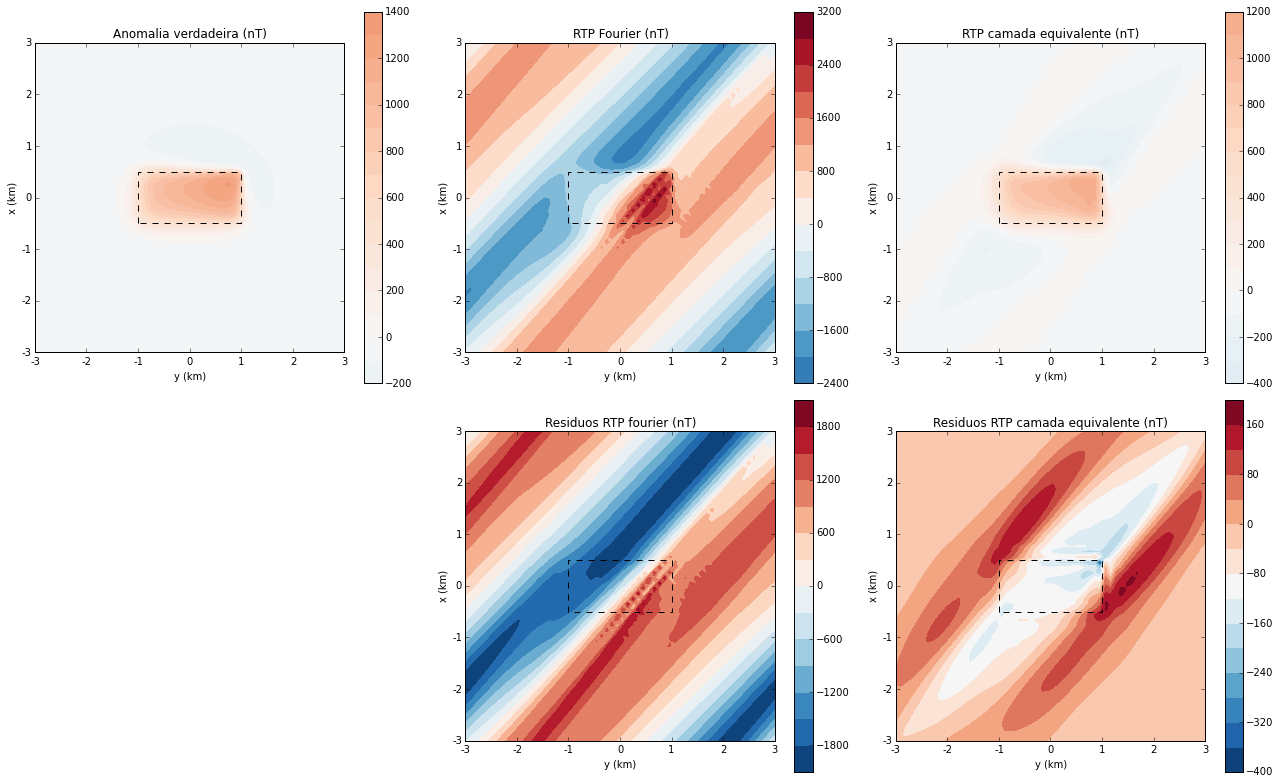

In [28]:
mpl.close('all')
mpl.figure(figsize=(18,11))

mpl.subplot(2,3,1)
mpl.title("Anomalia verdadeira (nT)")
mpl.axis('scaled')
mpl.contourf(yp, xp, dado_polo_verdadeiro, shape, 15, cmap=mpl.get_cmap('RdBu_r'), 
            vmin = -ranges, vmax=ranges)
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(2,3,2)
mpl.title("RTP Fourier (nT)")
mpl.axis('scaled')
mpl.contourf(yp, xp, dado_polo_fourier, shape, 15, cmap=mpl.get_cmap('RdBu_r'), 
            vmin = -ranges, vmax=ranges)
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(2,3,3)
mpl.title("RTP camada equivalente (nT)")
mpl.axis('scaled')
mpl.contourf(yp, xp, dado_polo_camada, shape, 15, cmap=mpl.get_cmap('RdBu_r'), 
            vmin = -ranges, vmax=ranges)
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(2,3,5)
mpl.title("Residuos RTP fourier (nT)")
mpl.axis('scaled')
mpl.contourf(yp, xp, dado_polo_fourier - dado_polo_verdadeiro, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(2,3,6)
mpl.title("Residuos RTP camada equivalente (nT)")
mpl.axis('scaled')
mpl.contourf(yp, xp, dado_polo_camada - dado_polo_verdadeiro, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.tight_layout()

mpl.show()